In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import zipfile  

In [2]:
!wget --no-check-certificate \
https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip

!wget --no-check-certificate \
https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip

--2020-09-14 17:46:33--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.107.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.107.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 200682221 (191M) [application/zip]
Saving to: ‘rps.zip’

rps.zip             100%[===================>] 191.38M   130MB/s    in 1.5s    

2020-09-14 17:46:35 (130 MB/s) - ‘rps.zip’ saved [200682221/200682221]

--2020-09-14 17:46:35--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 108.177.98.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29516758 (28M) [application/zip]
Saving to: ‘rps-test-set.z

In [3]:
zip_ref_train = zipfile.ZipFile('/content/rps.zip')
zip_ref_train.extractall()
zip_ref_train.close()

zip_ref_test = zipfile.ZipFile('/content/rps-test-set.zip')
zip_ref_test.extractall()
zip_ref_test.close()

In [4]:
train_dir = '/content/rps'
test_dir = '/content/rps-test-set'

train_paper_dir = os.path.join(train_dir, 'paper')
train_rock_dir = os.path.join(train_dir, 'rock') 
train_scissors_dir = os.path.join(train_dir, 'scissors')

test_paper_dir = os.path.join(test_dir, 'paper')
test_rock_dir = os.path.join(test_dir, 'rock') 
test_scissors_dir = os.path.join(test_dir, 'scissors')

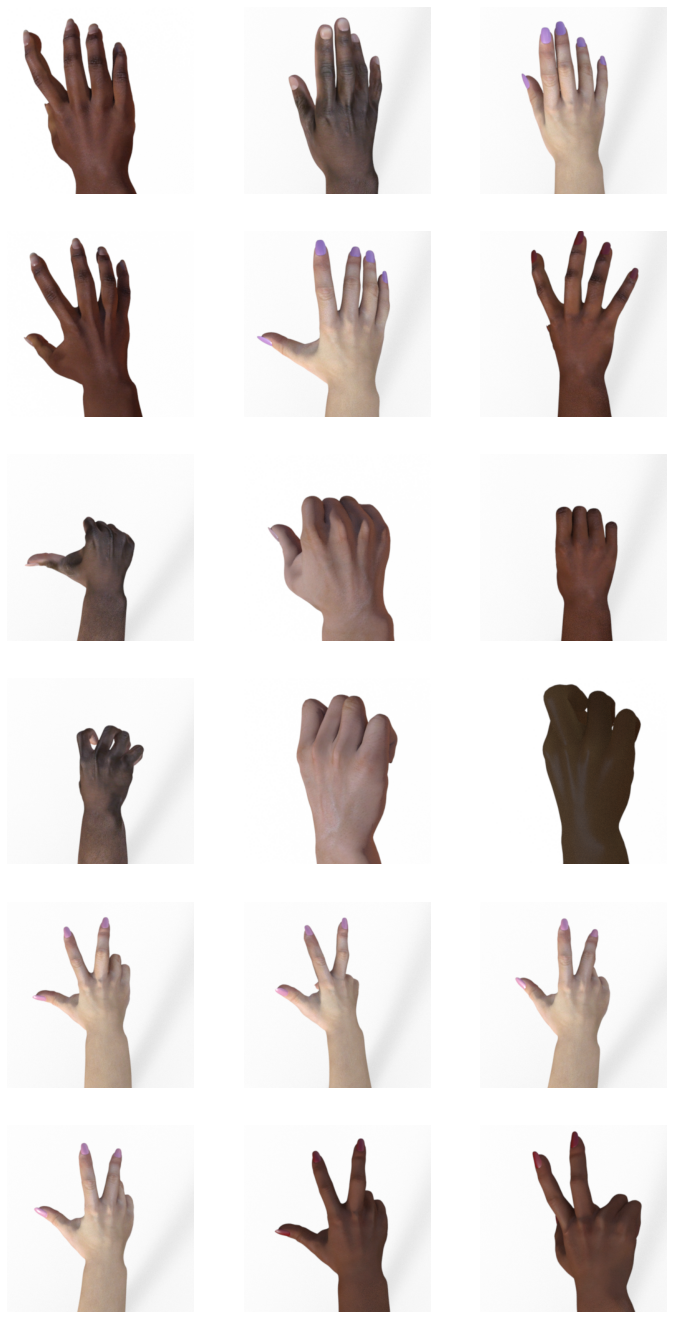

In [5]:
ncols = 6
nrows = 3
index = 0

fig = plt.gcf()
fig.set_size_inches(nrows*4, ncols*4)

index += 6
next_paper_pix = [os.path.join(train_paper_dir, fname) for fname in os.listdir(train_paper_dir)[index-6 : index]]
next_rock_pix = [os.path.join(train_rock_dir, fname) for fname in os.listdir(train_rock_dir)[index-6 : index]]
next_scissors_pix = [os.path.join(train_scissors_dir, fname) for fname in os.listdir(train_scissors_dir)[index-6 : index]]

for i, img_path in enumerate(next_paper_pix+next_rock_pix+next_scissors_pix):
  sp = plt.subplot(ncols, nrows, i+1)
  sp.axis('off')
  img = mpimg.imread(img_path)
  plt.imshow(img)

In [6]:
print(len(os.listdir(train_paper_dir))+len(os.listdir(train_rock_dir))+len(os.listdir(train_scissors_dir)))
print(len(os.listdir(test_paper_dir))+len(os.listdir(test_rock_dir))+len(os.listdir(test_scissors_dir)))

2520
372


In [11]:
train_datagen = ImageDataGenerator(rescale = 1/255,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   rotation_range = 40,
                                   horizontal_flip = True,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   fill_mode = 'nearest')
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 128,
                                                    target_size = (300, 300),
                                                    class_mode = 'categorical')

test_datagen = ImageDataGenerator(rescale = 1/255.0)
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  batch_size = 32,
                                                  target_size = (300, 300),
                                                  class_mode = 'categorical')

Found 2520 images belonging to 3 classes.
Found 372 images belonging to 3 classes.


In [16]:
model = tf.keras.Sequential([tf.keras.layers.Conv2D(16, (3, 3), activation = 'relu', input_shape = (300, 300, 3)),
                             tf.keras.layers.MaxPooling2D(2, 2),
                             tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
                             tf.keras.layers.MaxPooling2D(2, 2),
                             tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
                             tf.keras.layers.MaxPooling2D(2, 2),
                             tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
                             tf.keras.layers.MaxPooling2D(2, 2),
                             tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
                             tf.keras.layers.MaxPooling2D(2, 2),
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Dense(512, activation = 'relu'),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Dense(3, activation = 'softmax')])
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 33, 33, 64)        3

In [18]:
history = model.fit(train_generator,
                    steps_per_epoch = 8,
                    validation_data = test_generator,
                    validation_steps = 8,
                    epochs = 50,
                    verbose = 1)

Epoch 1/50
8/8 [==============================] - 19s 2s/step - loss: 1.1186 - accuracy: 0.3415 - val_loss: 1.0952 - val_accuracy: 0.3320
Epoch 2/50
8/8 [==============================] - 21s 3s/step - loss: 1.0968 - accuracy: 0.3252 - val_loss: 1.0844 - val_accuracy: 0.3398
Epoch 3/50
8/8 [==============================] - 21s 3s/step - loss: 1.0714 - accuracy: 0.4502 - val_loss: 1.0006 - val_accuracy: 0.5859
Epoch 4/50
8/8 [==============================] - 20s 2s/step - loss: 1.0021 - accuracy: 0.5051 - val_loss: 0.9472 - val_accuracy: 0.5469
Epoch 5/50
8/8 [==============================] - 20s 2s/step - loss: 0.8925 - accuracy: 0.5671 - val_loss: 0.6848 - val_accuracy: 0.7773
Epoch 6/50
8/8 [==============================] - 21s 3s/step - loss: 0.8080 - accuracy: 0.6035 - val_loss: 0.5508 - val_accuracy: 0.7344
Epoch 7/50
8/8 [==============================] - 20s 2s/step - loss: 0.7464 - accuracy: 0.6738 - val_loss: 0.5726 - val_accuracy: 0.6680
Epoch 8/50
8/8 [==================

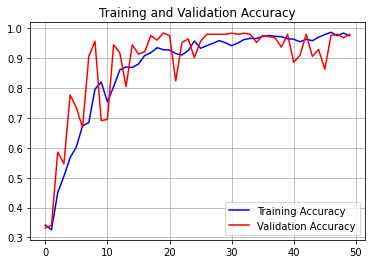

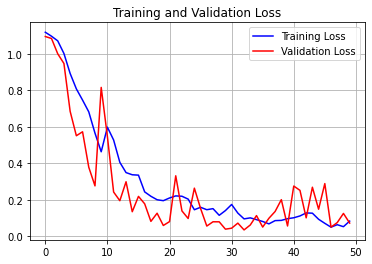

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, label = 'Training Accuracy', color = 'blue')
plt.plot(epochs, val_acc, label = 'Validation Accuracy', color = 'red')
plt.grid('on')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label = 'Training Loss', color = 'blue')
plt.plot(epochs, val_loss, label = 'Validation Loss',color = 'red')
plt.grid('on')
plt.title('Training and Validation Loss')
plt.legend()

In [24]:
train_generator.class_indices

{'paper': 0, 'rock': 1, 'scissors': 2}

In [31]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(300, 300))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = x/255.0
  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(fn)
  print(classes)

Saving scissors-hires2.png to scissors-hires2.png
scissors-hires2.png
[[3.1339715e-07 9.8939881e-06 9.9998975e-01]]
